In [1]:
import time
import numpy as np
import os
import path
import keras
import pydot
from typing import List, Tuple
from matplotlib.pyplot import imshow
%matplotlib inline
import matplotlib.pyplot as plt
import PIL.Image
import pathlib
import shutil

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.models import Model, load_model

from tensorflow.python.keras.utils import layer_utils
#from tensorflow.keras.utils.vis_utils import model_to_dot
from tensorflow.keras.utils import model_to_dot
from tensorflow.keras.utils import plot_model

from tensorflow.keras.applications.imagenet_utils import preprocess_input

from IPython.display import SVG

import scipy.misc

import tensorflow.keras.backend as K
K.set_image_data_format('channels_last') # can be channels_first or channels_last. 
K.set_learning_phase(1) # 1 stands for learning phase

C:\Users\JUHI\anaconda3\lib\site-packages\keras\backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


In [2]:
def identity_block(X: tf.Tensor, level: int, block: int, filters: List[int]) -> tf.Tensor:
    # layers will be called conv{level}_iden{block}_{convlayer_number_within_block}'
    conv_name = f'conv{level}_{block}' + '_{layer}_{type}'

    # unpack number of filters to be used for each conv layer
    f1, f2, f3 = filters

    # the shortcut branch of the identity block
    # takes the value of the block input
    X_shortcut = X
    # first convolutional layer (plus batch norm & relu activation, of course)
    X = Conv2D(filters=f1, kernel_size=(1, 1), strides=(1, 1),
               padding='valid', name=conv_name.format(layer=1, type='conv'),
               kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=conv_name.format(layer=1, type='bn'))(X)
    X = Activation('relu', name=conv_name.format(layer=1, type='relu'))(X)
    # second convolutional layer
    X = Conv2D(filters=f2, kernel_size=(3, 3), strides=(1, 1),
               padding='same', name=conv_name.format(layer=2, type='conv'),
               kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=conv_name.format(layer=2, type='bn'))(X)
    X = Activation('relu')(X)

    # third convolutional layer
    X = Conv2D(filters=f3, kernel_size=(1, 1), strides=(1, 1),
               padding='valid', name=conv_name.format(layer=3, type='conv'),
               kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=conv_name.format(layer=3, type='bn'))(X)
    # add shortcut branch to main path
    X = Add()([X, X_shortcut])

    # relu activation at the end of the block
    X = Activation('relu', name=conv_name.format(layer=3, type='relu'))(X)

    return X

In [3]:
def convolutional_block(X: tf.Tensor, level: int, block: int, filters: List[int], s: Tuple[int,int,int]=(2, 2)) -> tf.Tensor:
    # layers will be called conv{level}_{block}_{convlayer_number_within_block}'
    conv_name = f'conv{level}_{block}' + '_{layer}_{type}'

    # unpack number of filters to be used for each conv layer
    f1, f2, f3 = filters

    # the shortcut branch of the convolutional block
    X_shortcut = X
    # first convolutional layer
    X = Conv2D(filters=f1, kernel_size=(1, 1), strides=s, padding='valid',
               name=conv_name.format(layer=1, type='conv'),
               kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=conv_name.format(layer=1, type='bn'))(X)
    X = Activation('relu', name=conv_name.format(layer=1, type='relu'))(X)
    # second convolutional layer
    X = Conv2D(filters=f2, kernel_size=(3, 3), strides=(1, 1), padding='same',
               name=conv_name.format(layer=2, type='conv'),
               kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=conv_name.format(layer=2, type='bn'))(X)
    X = Activation('relu', name=conv_name.format(layer=2, type='relu'))(X)
    # third convolutional layer
    X = Conv2D(filters=f3, kernel_size=(1, 1), strides=(1, 1), padding='valid',
               name=conv_name.format(layer=3, type='conv'),
               kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=conv_name.format(layer=3, type='bn'))(X)
    # shortcut path
    X_shortcut = Conv2D(filters=f3, kernel_size=(1, 1), strides=s, padding='valid',
                        name=conv_name.format(layer='short', type='conv'),
                        kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=conv_name.format(layer='short', type='bn'))(X_shortcut)

    # add shortcut branch to main path
    X = Add()([X, X_shortcut])

    # nonlinearity
    X = Activation('relu', name=conv_name.format(layer=3, type='relu'))(X)
    
    return X

In [4]:
def ResNet50(input_size: Tuple[int,int,int], classes: int) -> Model:
    # tensor placeholder for the model's input
    X_input = Input(input_size)

    ### Level 1 ###

    # padding
    X = ZeroPadding2D((3, 3))(X_input)

    # convolutional layer, followed by batch normalization and relu activation
    X = Conv2D(filters=64, kernel_size=(7, 7), strides=(2, 2),
               name='conv1_1_1_conv',
               kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='conv1_1_1_nb')(X)
    X = Activation('relu')(X)
    
    ### Level 2 ###

    # max pooling layer to halve the size coming from the previous layer
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # 1x convolutional block
    X = convolutional_block(X, level=2, block=1, filters=[64, 64, 256], s=(1, 1))

    # 2x identity blocks
    X = identity_block(X, level=2, block=2, filters=[64, 64, 256])
    X = identity_block(X, level=2, block=3, filters=[64, 64, 256])
    
    ### Level 3 ###

    # 1x convolutional block
    X = convolutional_block(X, level=3, block=1, filters=[128, 128, 512], s=(2, 2))

    # 3x identity blocks
    X = identity_block(X, level=3, block=2, filters=[128, 128, 512])
    X = identity_block(X, level=3, block=3, filters=[128, 128, 512])
    X = identity_block(X, level=3, block=4, filters=[128, 128, 512])
    
    ### Level 4 ###
    # 1x convolutional block
    X = convolutional_block(X, level=4, block=1, filters=[256, 256, 1024], s=(2, 2))
    # 5x identity blocks
    X = identity_block(X, level=4, block=2, filters=[256, 256, 1024])
    X = identity_block(X, level=4, block=3, filters=[256, 256, 1024])
    X = identity_block(X, level=4, block=4, filters=[256, 256, 1024])
    X = identity_block(X, level=4, block=5, filters=[256, 256, 1024])
    X = identity_block(X, level=4, block=6, filters=[256, 256, 1024])
    
    ### Level 5 ###
    # 1x convolutional block
    X = convolutional_block(X, level=5, block=1, filters=[512, 512, 2048], s=(2, 2))
    # 2x identity blocks
    X = identity_block(X, level=5, block=2, filters=[512, 512, 2048])
    X = identity_block(X, level=5, block=3, filters=[512, 512, 2048])

    # Pooling layers
    X = AveragePooling2D(pool_size=(2, 2), name='avg_pool')(X)
    
    # Output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc_' + str(classes),
              kernel_initializer=glorot_uniform(seed=0))(X)

    # Create model
    model = Model(inputs=X_input, outputs=X, name='ResNet50')

    return model

In [5]:
# set input image parameters
image_size = (64, 64) 
channels = 3
num_classes = 10

In [6]:
model = ResNet50(input_size = (image_size[1], image_size[0], channels), classes = num_classes)

In [7]:
model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 70, 70, 3)   0           ['input_1[0][0]']                
                                                                                                  
 conv1_1_1_conv (Conv2D)        (None, 32, 32, 64)   9472        ['zero_padding2d[0][0]']         
                                                                                                  
 conv1_1_1_nb (BatchNormalizati  (None, 32, 32, 64)  256         ['conv1_1_1_conv[0][0]']         
 on)                                                                                       

 conv2_3_3_conv (Conv2D)        (None, 15, 15, 256)  16640       ['activation_2[0][0]']           
                                                                                                  
 conv2_3_3_bn (BatchNormalizati  (None, 15, 15, 256)  1024       ['conv2_3_3_conv[0][0]']         
 on)                                                                                              
                                                                                                  
 add_2 (Add)                    (None, 15, 15, 256)  0           ['conv2_3_3_bn[0][0]',           
                                                                  'conv2_2_3_relu[0][0]']         
                                                                                                  
 conv2_3_3_relu (Activation)    (None, 15, 15, 256)  0           ['add_2[0][0]']                  
                                                                                                  
 conv3_1_1

                                                                  'conv3_2_3_relu[0][0]']         
                                                                                                  
 conv3_3_3_relu (Activation)    (None, 8, 8, 512)    0           ['add_5[0][0]']                  
                                                                                                  
 conv3_4_1_conv (Conv2D)        (None, 8, 8, 128)    65664       ['conv3_3_3_relu[0][0]']         
                                                                                                  
 conv3_4_1_bn (BatchNormalizati  (None, 8, 8, 128)   512         ['conv3_4_1_conv[0][0]']         
 on)                                                                                              
                                                                                                  
 conv3_4_1_relu (Activation)    (None, 8, 8, 128)    0           ['conv3_4_1_bn[0][0]']           
          

 conv4_3_1_bn (BatchNormalizati  (None, 4, 4, 256)   1024        ['conv4_3_1_conv[0][0]']         
 on)                                                                                              
                                                                                                  
 conv4_3_1_relu (Activation)    (None, 4, 4, 256)    0           ['conv4_3_1_bn[0][0]']           
                                                                                                  
 conv4_3_2_conv (Conv2D)        (None, 4, 4, 256)    590080      ['conv4_3_1_relu[0][0]']         
                                                                                                  
 conv4_3_2_bn (BatchNormalizati  (None, 4, 4, 256)   1024        ['conv4_3_2_conv[0][0]']         
 on)                                                                                              
                                                                                                  
 activatio

                                                                                                  
 conv4_6_3_conv (Conv2D)        (None, 4, 4, 1024)   263168      ['activation_10[0][0]']          
                                                                                                  
 conv4_6_3_bn (BatchNormalizati  (None, 4, 4, 1024)  4096        ['conv4_6_3_conv[0][0]']         
 on)                                                                                              
                                                                                                  
 add_12 (Add)                   (None, 4, 4, 1024)   0           ['conv4_6_3_bn[0][0]',           
                                                                  'conv4_5_3_relu[0][0]']         
                                                                                                  
 conv4_6_3_relu (Activation)    (None, 4, 4, 1024)   0           ['add_12[0][0]']                 
          

 add_15 (Add)                   (None, 2, 2, 2048)   0           ['conv5_3_3_bn[0][0]',           
                                                                  'conv5_2_3_relu[0][0]']         
                                                                                                  
 conv5_3_3_relu (Activation)    (None, 2, 2, 2048)   0           ['add_15[0][0]']                 
                                                                                                  
 avg_pool (AveragePooling2D)    (None, 1, 1, 2048)   0           ['conv5_3_3_relu[0][0]']         
                                                                                                  
 flatten (Flatten)              (None, 2048)         0           ['avg_pool[0][0]']               
                                                                                                  
 fc_10 (Dense)                  (None, 10)           20490       ['flatten[0][0]']                
          

In [8]:
'''plt.figure(figsize=(20,20))
classes = ['Normal_liver','Steatohepatitis','Steatosis']
for i in range(1,26):
    index = np.random.randint(x_train.shape[0])
    plt.subplot(5, 5, i)
    plt.imshow(np.squeeze(x_train[index]), cmap='hot')
    plt.title(classes[int(y_train[index])])
    plt.tight_layout()
plt.show()'''

"plt.figure(figsize=(20,20))\nclasses = ['Normal_liver','Steatohepatitis','Steatosis']\nfor i in range(1,26):\n    index = np.random.randint(x_train.shape[0])\n    plt.subplot(5, 5, i)\n    plt.imshow(np.squeeze(x_train[index]), cmap='hot')\n    plt.title(classes[int(y_train[index])])\n    plt.tight_layout()\nplt.show()"

In [9]:
in_folder = os.path.join('D:/AMITY/NTCC-3 (INTERNSHIP) 2023/AI/Dataset/Training')

file_count = []

# get number of images in each folder (images per class)
for fld in os.listdir(in_folder):
    crt = os.path.join(in_folder, fld)
    
    image_count = len(os.listdir(crt))
    
    file_count.append(image_count)
    
    print(f'{crt} contains {image_count} images')

D:/AMITY/NTCC-3 (INTERNSHIP) 2023/AI/Dataset/Training\Normal_liver contains 42 images
D:/AMITY/NTCC-3 (INTERNSHIP) 2023/AI/Dataset/Training\Steatohepatitis contains 66 images
D:/AMITY/NTCC-3 (INTERNSHIP) 2023/AI/Dataset/Training\Steatosis contains 46 images


In [10]:
print(f'Total number of images: {sum(file_count)}')

Total number of images: 154


In [11]:
os.listdir(os.path.join(in_folder, 'Normal_liver'))[:10]

['1.JPG',
 '10.tif',
 '11.JPG',
 '12.JPG',
 '13.JPG',
 '14.JPG',
 '15.png',
 '16.png',
 '17.png',
 '18.tif']

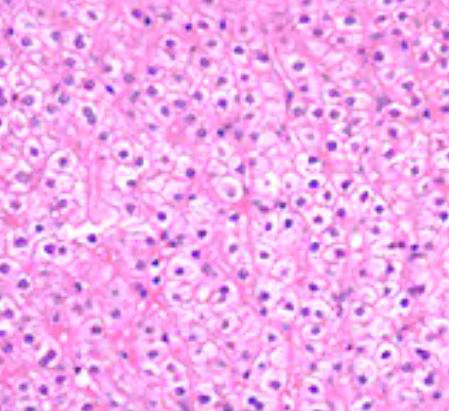

In [12]:
data_dir = pathlib.Path(in_folder)

Normal_liver = list(data_dir.glob('Normal_liver/*'))

PIL.Image.open(str(Normal_liver[0]))

In [13]:
PIL.Image.open(str(Normal_liver[0])).size

(449, 411)

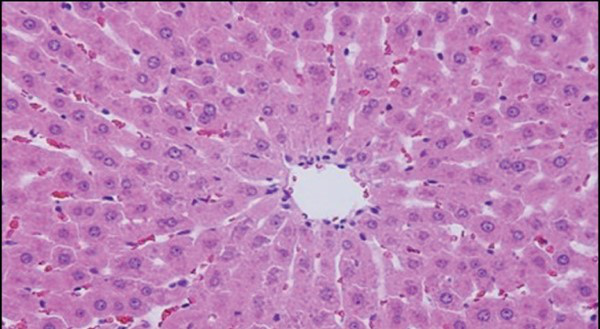

In [14]:
PIL.Image.open(str(Normal_liver[10]))

In [15]:
out_folder = os.path.join('D:/AMITY/NTCC-3 (INTERNSHIP) 2023/AI/Dataset/Processed')

In [16]:
def square_crop_image(im: PIL.Image) -> PIL.Image:
    width, height = im.size
    new_size = min(width, height)

    # center crop
    left = (width - new_size) / 2
    top = (height - new_size) / 2
    right = (width + new_size) / 2
    bottom = (height + new_size) / 2

    crop_im = im.crop((left, top, right, bottom))
    crop_im = crop_im.convert('RGB')

    return crop_im

In [17]:
def make_dataset(in_folder, im_per_class):
    # iterate through all folders (there should be one folder per object class)
    for fld in os.listdir(in_folder):
        # create the output folder for processed images for current class
        # delete folder and contents if there is one already
        out = os.path.join(out_folder, fld)
        if os.path.exists(out):
            shutil.rmtree(out)
        os.makedirs(out)
        
        fld_path = pathlib.Path(os.path.join(in_folder, fld))
        num_images = 0
        for file in list(fld_path.glob('*')):
            # open image, center crop to a square
            # save to the output folder
            with PIL.Image.open(file) as im:
                crop_im = square_crop_image(im)
                crop_im.save(os.path.join(out, str(num_images) + '.jpg'))
                im.close()
            # break when desired number of images
            # has been processed (to keep classes balance)
            num_images = num_images + 1
            
            print(num_images)
            
            if (num_images > im_per_class):
                break

In [ ]:
# get the number of images that will make our classes balanced
print(file_count)
im_per_class = min(file_count)

# process input images 
make_dataset(in_folder, im_per_class)

In [ ]:
img_height = image_size[1]
img_width = image_size[0]
batch_size = 32

In [ ]:
data_dir = pathlib.Path(out_folder)